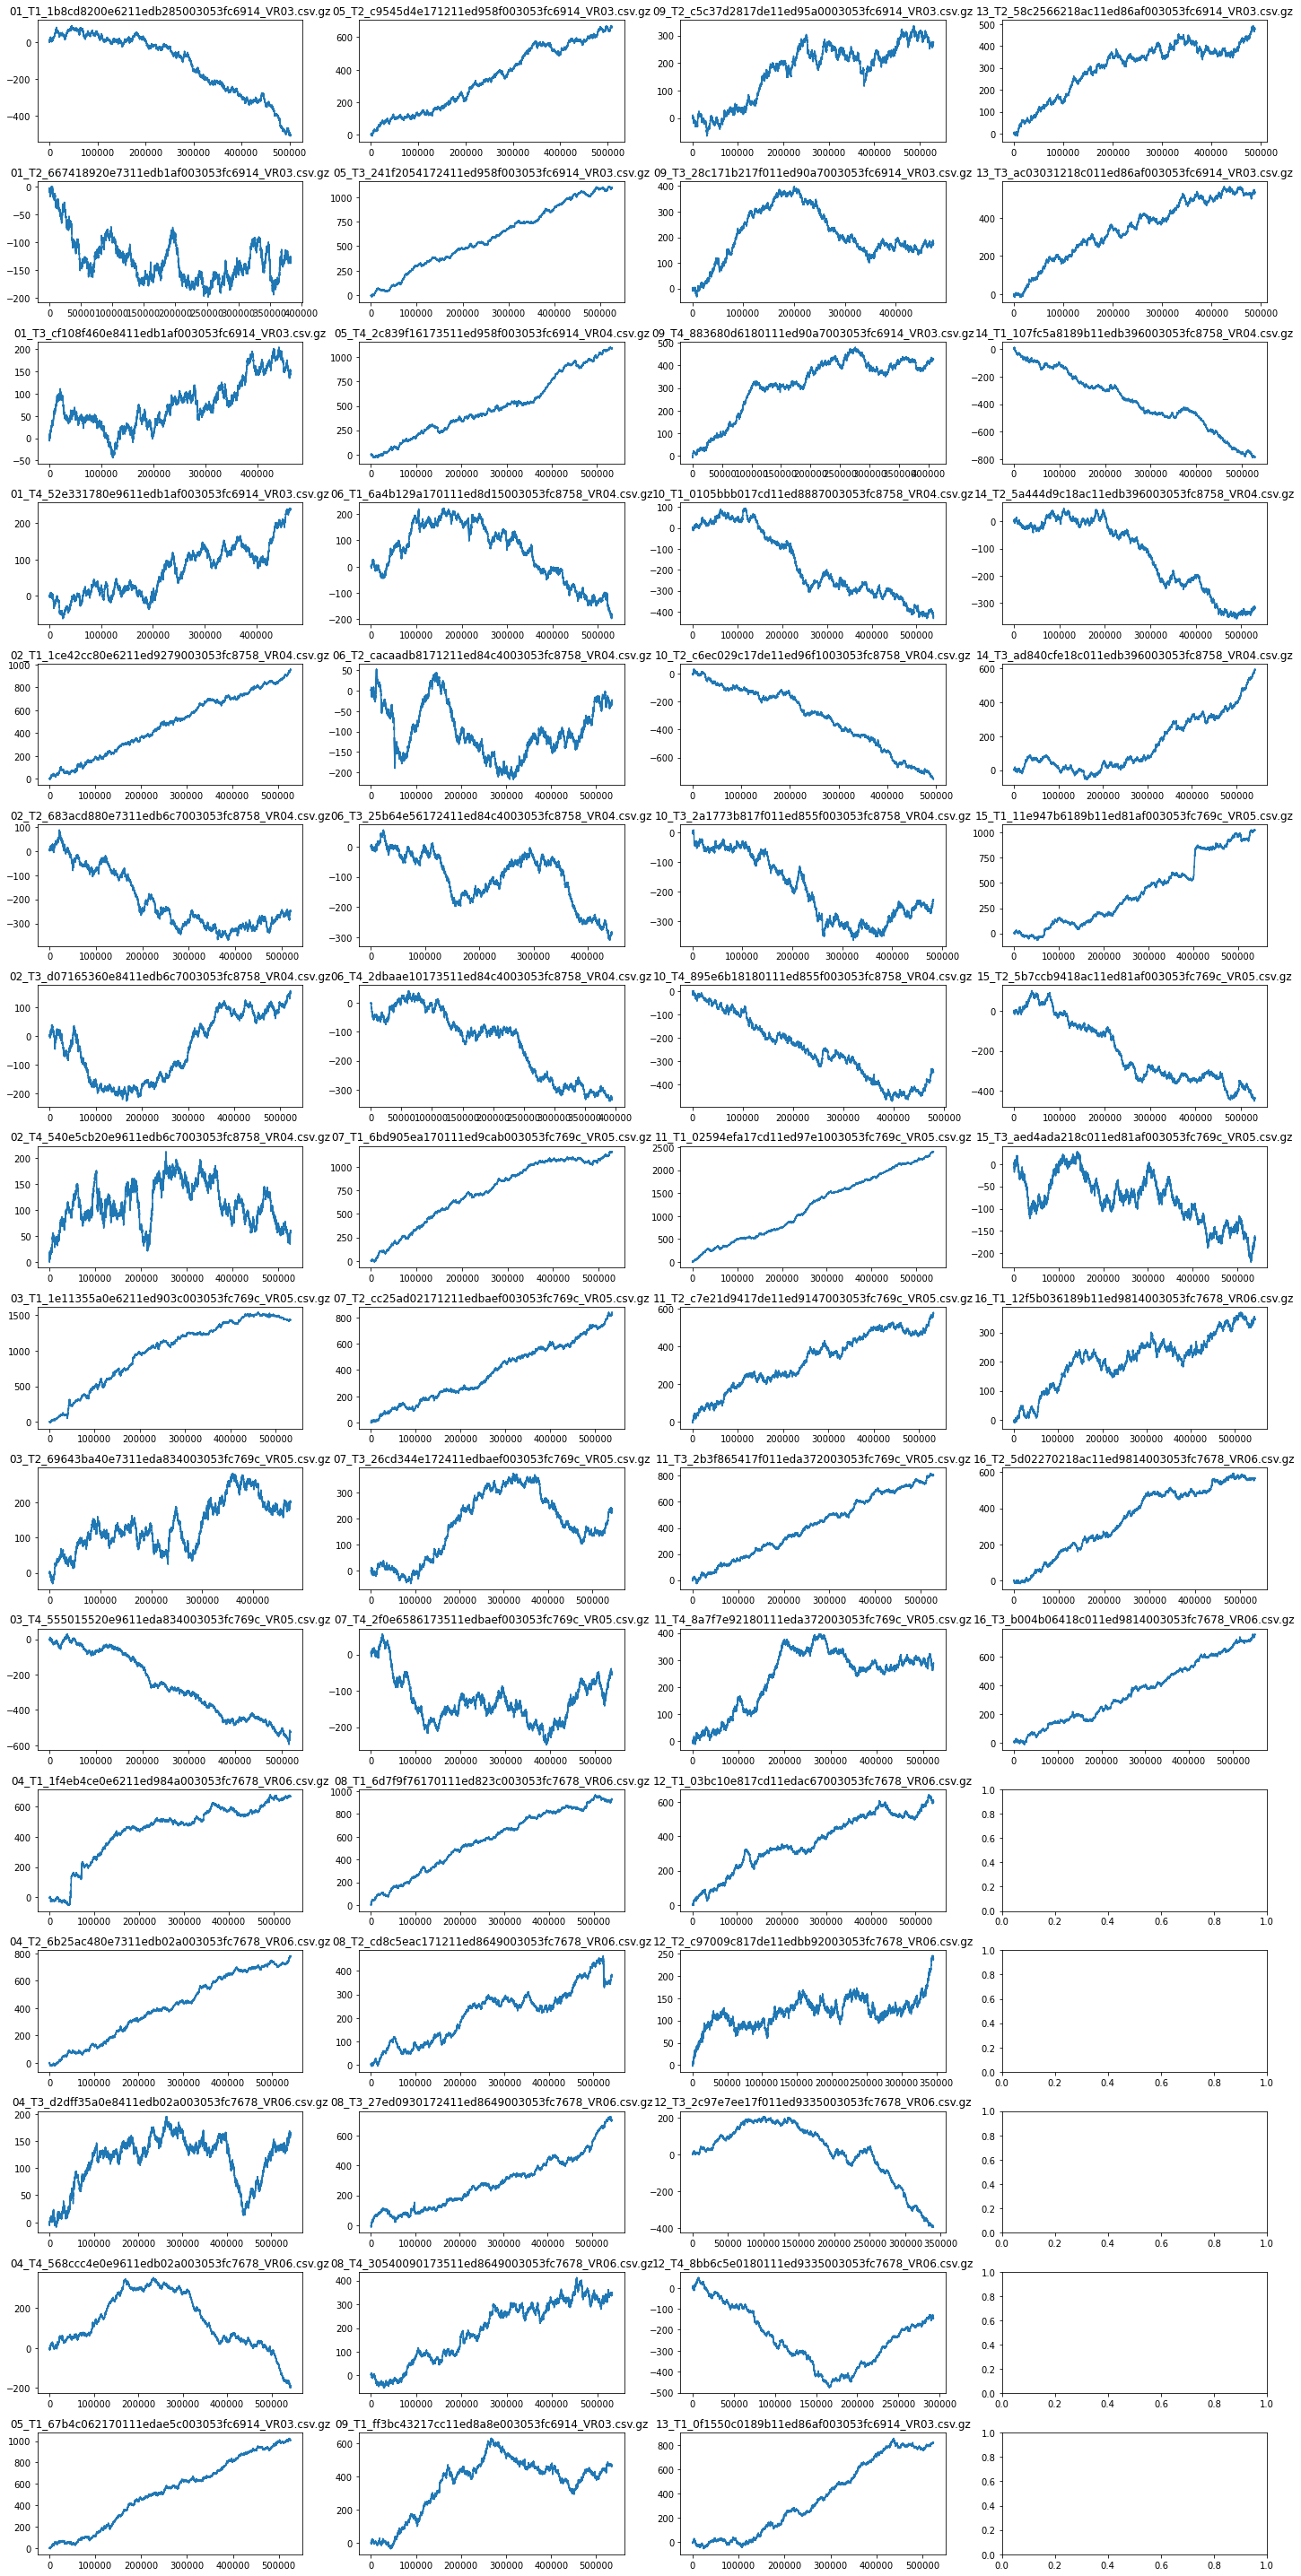

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip

desired_cols = ['fishz', 'fishy', 'fishx', 'realtime']

# Define the path to the folder containing the compressed CSV files
path = "/home/kkumari/PhD/fish-data/long-term-free-swim/"

# Get all compressed CSV files in the folder and sort them by name
all_files = sorted(glob.glob(os.path.join(path, "*.csv.gz")))

# Initialize figure and subplots
fig, axes = plt.subplots(16, 4, figsize=(20, 40))

# Iterate over each file and plot angles in the corresponding subplot
for i, file in enumerate(all_files):
    # Read data from compressed CSV file
    with gzip.open(file, 'rb') as f:
        df = pd.read_csv(f, usecols=desired_cols)

    if not df.empty:
        zs = df["fishx"].rolling(window=11, center=True).mean().interpolate(method="pad")
        ys = df["fishy"].rolling(window=11, center=True).mean().interpolate(method="pad")
        xs = df["fishz"].rolling(window=11, center=True).mean().interpolate(method="pad")
        dx = xs.diff().interpolate(method='bfill')
        dy = ys.diff().interpolate(method='bfill')
        dz = zs.diff().interpolate(method='bfill')

        df["dx"] = dx
        df["dy"] = dy
        df["dz"] = dz

        angle_wrappeds = np.arctan2(dy, dx)

        # Angle unwrapping
        last = 0
        angles = []
        for j in range(len(dx)):
            phi = np.arctan2(dy[j], dx[j])
            while phi < last - np.pi:
                phi += 2 * np.pi
            while phi > last + np.pi:
                phi -= 2 * np.pi
            last = phi
            angles.append(phi)

        angles = np.array(angles)

        # Calculate the subplot indices
        row = i % 16  # Calculate the row index
        col = i // 16  # Calculate the column index

        # Plot angles in the corresponding subplot
        axes[row, col].plot(angles)
        axes[row, col].set_title(os.path.basename(file))  # Set the subplot title as the filename
    else:
        # If df is empty, leave the subplot empty
        axes[i % 16, i // 16].axis('off')

# Adjust subplot spacing and labels
plt.tight_layout()
plt.show()


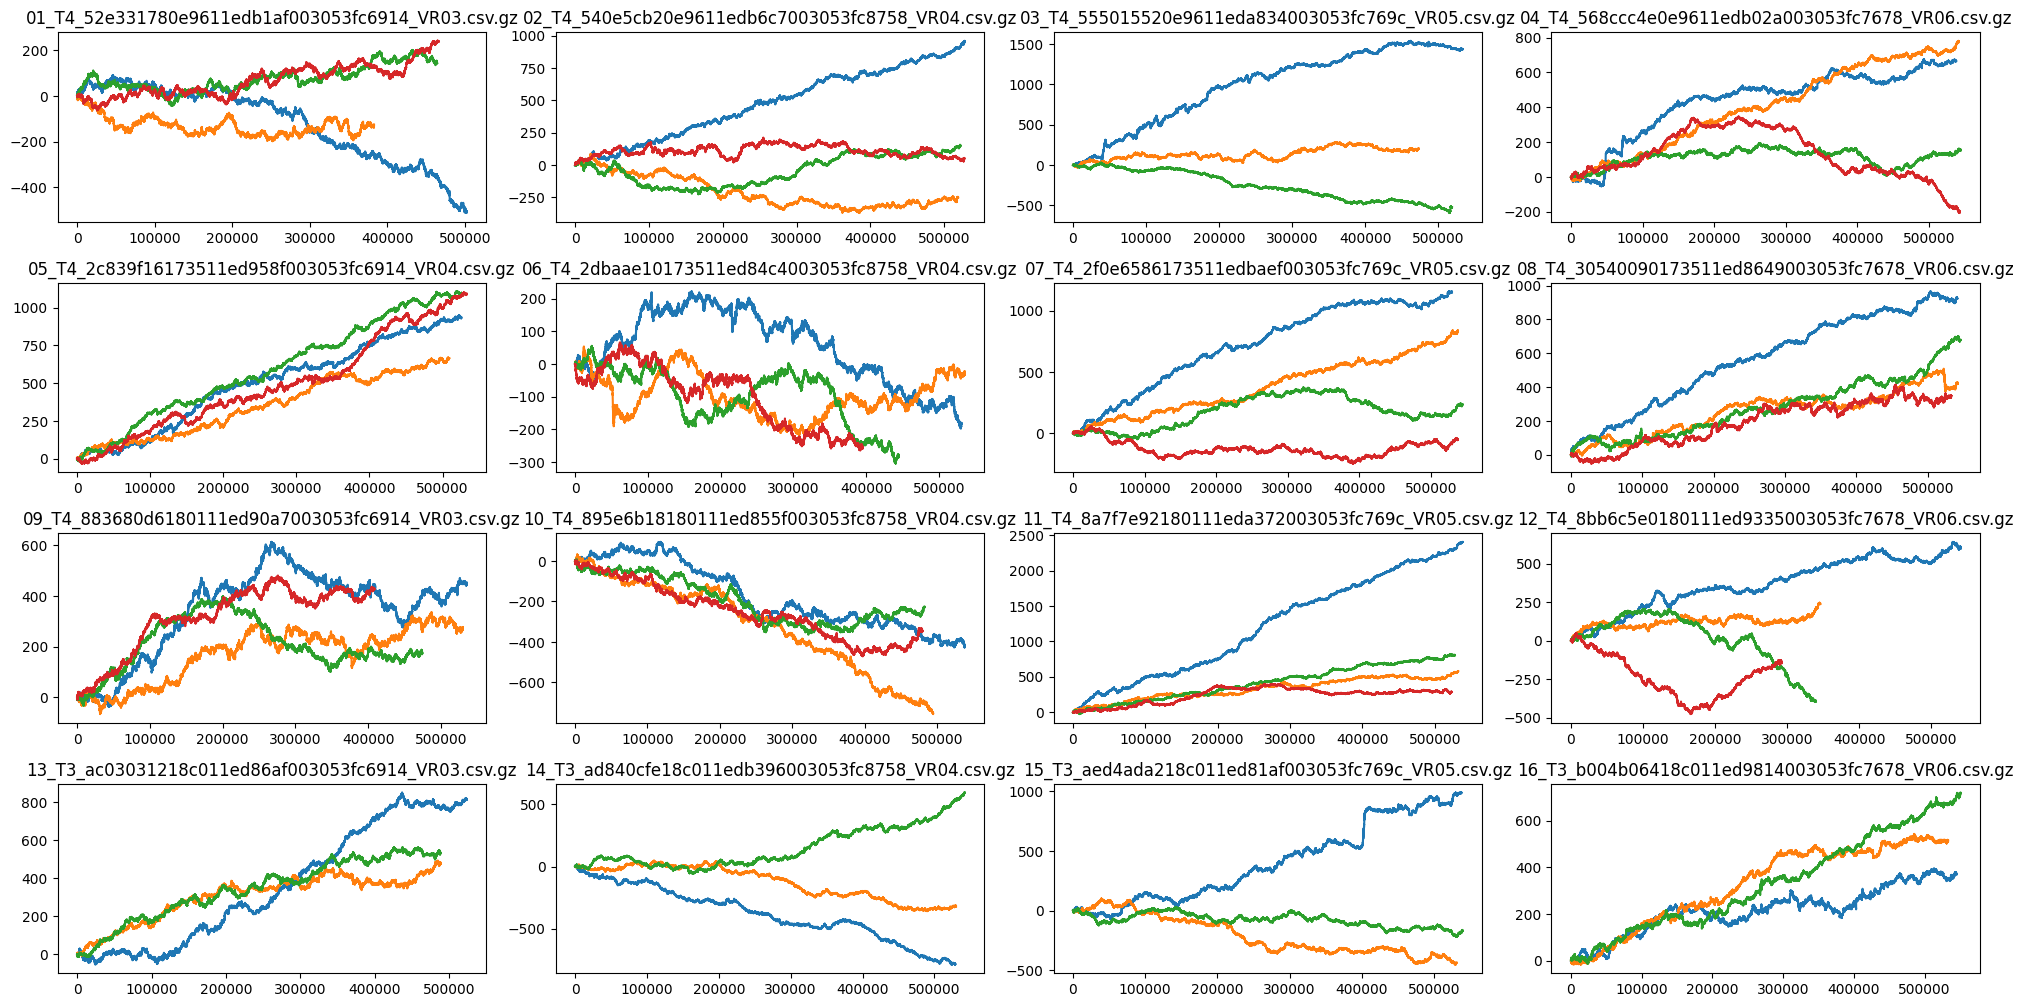

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip

desired_cols = ['fishz', 'fishy', 'fishx', 'realtime']

# Define the path to the folder containing the compressed CSV files
path = "/home/kkumari/PhD/fish-data/long-term-free-swim/"
# Get all compressed CSV files in the folder and sort them by name
all_files = sorted(glob.glob(os.path.join(path, "*.csv.gz")))

# Create a dictionary to store fish IDs and their corresponding subplot indices
fish_ids = {}

# Assign subplot indices to fish IDs
for i, file in enumerate(all_files):
    # Get the fish ID from the first two letters of the filename
    fish_id = os.path.basename(file)[:2]
    if fish_id not in fish_ids:
        fish_ids[fish_id] = len(fish_ids)  # Assign a new index to the fish ID

# Create a 16x4 grid of subplots
fig, axes = plt.subplots(16, 4, figsize=(20, 40))

# Iterate over each file and plot angles in the corresponding subplot
for i, file in enumerate(all_files):
    # Read data from compressed CSV file
    with gzip.open(file, 'rb') as f:
        df = pd.read_csv(f, usecols=desired_cols)

    zs = df["fishx"].rolling(window=11, center=True).mean().interpolate(method="pad")
    ys = df["fishy"].rolling(window=11, center=True).mean().interpolate(method="pad")
    xs = df["fishz"].rolling(window=11, center=True).mean().interpolate(method="pad")
    dx = xs.diff().interpolate(method='bfill')
    dy = ys.diff().interpolate(method='bfill')
    dz = zs.diff().interpolate(method='bfill')

    df["dx"] = dx
    df["dy"] = dy
    df["dz"] = dz

    angle_wrappeds = np.arctan2(dy, dx)

    # Angle unwrapping
    last = 0
    angles = []
    for j in range(len(dx)):
        phi = np.arctan2(dy[j], dx[j])
        while phi < last - np.pi:
            phi += 2 * np.pi
        while phi > last + np.pi:
            phi -= 2 * np.pi
        last = phi
        angles.append(phi)

    angles = np.array(angles)

    # Get the fish ID from the first two letters of the filename
    fish_id = os.path.basename(file)[:2]

    if fish_id in fish_ids:
        # Get the subplot indices for the fish ID
        row = fish_ids[fish_id] // 4  # Calculate the row index
        col = fish_ids[fish_id] % 4  # Calculate the column index

        # Plot angles in the corresponding subplot
        axes[row, col].plot(angles)
        axes[row, col].set_title(os.path.basename(file))  # Set the subplot title as the filename

# Remove empty subplots
for i in range(16):
    for j in range(4):
        if not any(axes[i, j].get_lines()):
            fig.delaxes(axes[i, j])

# Adjust subplot spacing and labels
plt.tight_layout()
plt.show()
